In [1]:
!pip install transformers datasets torch scikit-learn pandas wordcloud xgboost


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from datasets import load_dataset

# Load SST5 dataset
sst5_dataset = load_dataset("SetFit/sst5")
train_data = sst5_dataset["train"]
train_data[0]

Repo card metadata block was not found. Setting CardData to empty.


{'text': 'a stirring , funny and finally transporting re-imagining of beauty and the beast and 1930s horror films',
 'label': 4,
 'label_text': 'very positive'}

In [3]:
twitter_dataset = load_dataset("tweet_eval", "sentiment")
twt_train_data = twitter_dataset["train"]
twt_train_data[0]

{'text': '"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"',
 'label': 2}

In [4]:
print(sst5_dataset)
print(sst5_dataset["train"].column_names)


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 8544
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 1101
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2210
    })
})
['text', 'label', 'label_text']


In [5]:
print(twitter_dataset)
print(twitter_dataset["train"].column_names)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 45615
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 12284
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})
['text', 'label']


In [6]:
def convert_sst5(example):
    label = int(example["label"])
    # label = example["label"]
    if label in [0, 1]:
        return {"text": example["text"], "label": 0}
    elif label == 2:
        return {"text": example["text"], "label": 1}
    else:
        return {"text": example["text"], "label": 2}

# sst5_mapped = sst5_dataset.map(convert_sst5)
sst5_mapped = sst5_dataset.map(convert_sst5, remove_columns=["label_text"])
print(sst5_mapped["train"][0])
print(sst5_dataset["train"][0])


{'text': 'a stirring , funny and finally transporting re-imagining of beauty and the beast and 1930s horror films', 'label': 2}
{'text': 'a stirring , funny and finally transporting re-imagining of beauty and the beast and 1930s horror films', 'label': 4, 'label_text': 'very positive'}


In [7]:
from datasets import DatasetDict, Value

def convert_twitter(example):
    return {"text": example["text"], "label": int(example["label"])}


twitter_mapped = twitter_dataset.map(convert_twitter)
print(twitter_mapped["train"][0])

# Force label column to be int64 instead of ClassLabel

# twitter_mapped = DatasetDict({
#     split: ds.cast_column("label", Value("int64"))
#     for split, ds in twitter_dataset.items()
# })



{'text': '"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"', 'label': 2}


In [8]:
from datasets import concatenate_datasets, DatasetDict
from datasets import ClassLabel

# Define common ClassLabel
label_class = ClassLabel(names=["negative", "neutral", "positive"])

# Ensure label columns are the same type before combining
sst5_mapped = sst5_mapped.cast_column("label", label_class)
twitter_mapped = twitter_mapped.cast_column("label", label_class)

full_combined_dataset = concatenate_datasets([
    sst5_mapped["train"], 
    sst5_mapped["test"], 
    twitter_mapped["train"], 
    twitter_mapped["test"],
    sst5_mapped["validation"], 
    twitter_mapped["validation"]
    
])

# Shuffled
full_combined_dataset = full_combined_dataset.shuffle(seed=42)




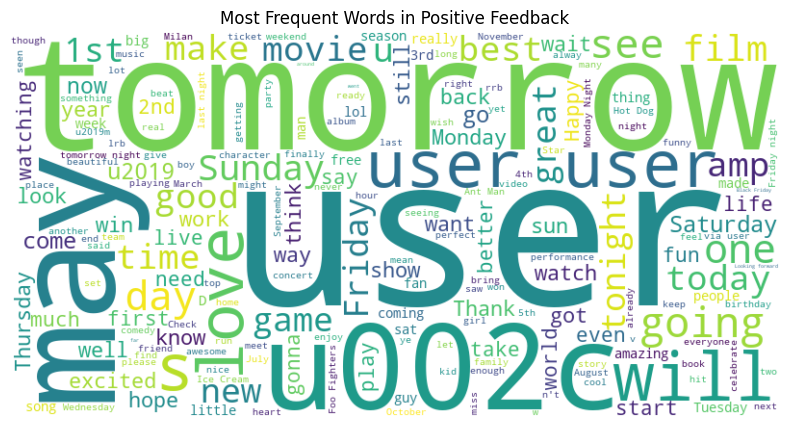

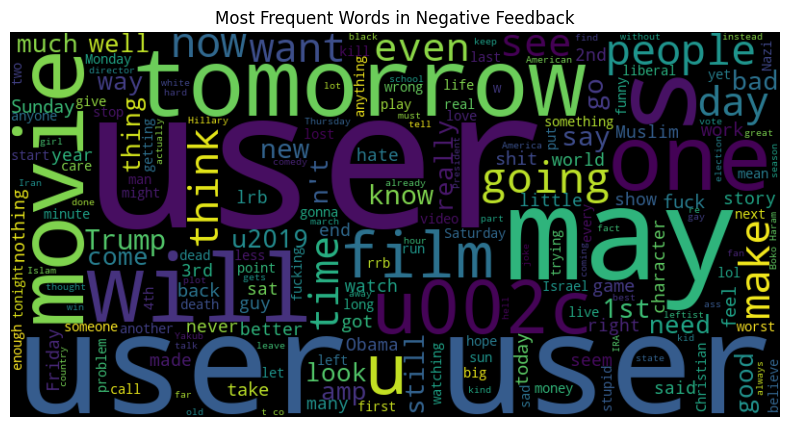

In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Get positive and negative texts using .filter()
positive_examples = full_combined_dataset.filter(lambda x: x["label"] == 2)
negative_examples = full_combined_dataset.filter(lambda x: x["label"] == 0)

# Join all texts into a single string
positive_texts = " ".join(positive_examples["text"])
negative_texts = " ".join(negative_examples["text"])

# WordCloud for positive feedback
wordcloud_pos = WordCloud(width=800, height=400, background_color="white").generate(positive_texts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Positive Feedback")
plt.show()

# WordCloud for negative feedback
wordcloud_neg = WordCloud(width=800, height=400, background_color="black").generate(negative_texts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Negative Feedback")
plt.show()


In [10]:
# Split the combined dataset (80% train, 20% test)
combined_dataset = full_combined_dataset.train_test_split(
    test_size=0.2,
    stratify_by_column="label"  # makes sure all labels are balanced
)

combined_train = combined_dataset["train"]
combined_test = combined_dataset["test"]

In [11]:
import re
import string

def clean_text(combined_train):
    combined_train = combined_train.lower()
    combined_train = re.sub(r"http\S+|www\S+|https\S+", '', combined_train, flags=re.MULTILINE)  # Remove URLs
    combined_train = re.sub(r'\@\w+|\#', '', combined_train)  # Remove @mentions and hashtags
    combined_train = combined_train.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    combined_train = re.sub(r'\d+', '', combined_train)  # Remove digits
    combined_train = re.sub(r'\s+', ' ', combined_train).strip()  # Remove extra whitespaces
    return combined_train


In [12]:
from collections import Counter

label_counts = Counter(combined_train['label'])
print(label_counts)


Counter({1: 23777, 2: 20805, 0: 12821})


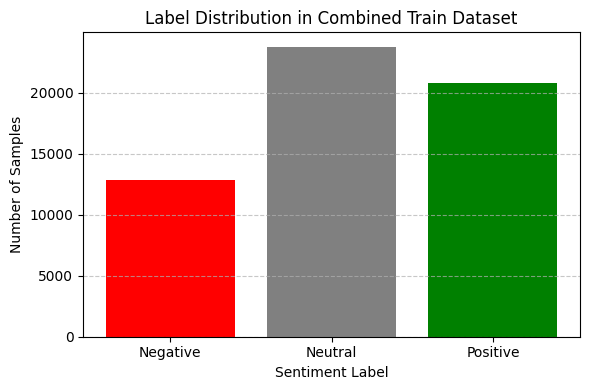

In [13]:
# Count the number of each label
# label_counts = Counter(combined_train['label'])

# Convert keys and values to lists for plotting
labels = list(label_counts.keys())
counts = list(label_counts.values())

# names for readability
label_names = ['Neutral', 'Positive', 'Negative']

# Plot
plt.figure(figsize=(6, 4))
plt.bar(labels, counts, tick_label=label_names, color=['gray', 'green', 'red'])
plt.title("Label Distribution in Combined Train Dataset")
plt.xlabel("Sentiment Label")
plt.ylabel("Number of Samples")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [14]:
label_counts_test = Counter(combined_test['label'])
print(label_counts_test)


Counter({1: 5944, 2: 5201, 0: 3206})


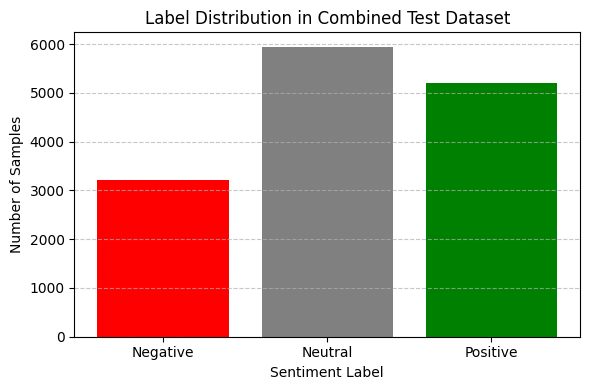

In [15]:
# Count the number of each label
# label_counts = Counter(combined_train['label'])

# Convert keys and values to lists for plotting
labels_test = list(label_counts_test.keys())
counts_test = list(label_counts_test.values())

# names for readability
label_names_test = ['Positive', 'Neutral', 'Negative']

# Plot
plt.figure(figsize=(6, 4))
plt.bar(labels_test, counts_test, tick_label=label_names_test , color=['green', 'gray', 'red'])

# plt.bar(labels_test, counts_test, tick_label=label_names, color=['red', 'green', 'gray'])
plt.title("Label Distribution in Combined Test Dataset")
plt.xlabel("Sentiment Label")
plt.ylabel("Number of Samples")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [16]:
import torch

In [17]:
full_combined_dataset.column_names

['text', 'label']

In [18]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Class labels
class_labels = [0, 1, 2]

# Corresponding labels from your dataset (flattened list of all labels)
# Assuming `all_labels` is your list or array of all labels
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array(class_labels),
    y=combined_train['label']  # Replace with your full label list
)

print(class_labels, class_weights)


[0, 1, 2] [1.49242129 0.80474128 0.91969879]


In [57]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import numpy as np

# Load tokenizer and model
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)


# Tokenize data
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)

tokenized_datasets_train = combined_train.map(tokenize_function, batched=True)
tokenized_datasets_test = combined_test.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


# Define compute_metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}

# Training setup
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
trainer.train()



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/57403 [00:00<?, ? examples/s]

Map:   0%|          | 0/14351 [00:00<?, ? examples/s]

C:\Users\shada\AppData\Local\Temp\ipykernel_7012\1270727851.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.784000,0.622415,0.722598
2,0.518800,0.641905,0.724618
3,0.357800,0.743242,0.722807
4,0.276600,0.941639,0.715978
5,0.221900,1.165221,0.712355


TrainOutput(global_step=17940, training_loss=0.39707445282999887, metrics={'train_runtime': 2837.7643, 'train_samples_per_second': 101.141, 'train_steps_per_second': 6.322, 'total_flos': 3368044967685210.0, 'train_loss': 0.39707445282999887, 'epoch': 5.0})

In [19]:
import torch
import torch.nn as nn
from transformers import DistilBertForSequenceClassification

# Defining weights from earlier 
weights = torch.tensor(class_weights, dtype=torch.float)

class WeightedLossDistilBERT(DistilBertForSequenceClassification):
    def __init__(self, config, weight):
        super().__init__(config)
        self.weight = weight

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        output = super().forward(input_ids=input_ids, attention_mask=attention_mask, labels=None)
        logits = output.logits
        loss_fn = nn.CrossEntropyLoss(weight=self.weight.to(logits.device))
        loss = loss_fn(logits, labels)
        return {"loss": loss, "logits": logits}


In [ ]:
from transformers import AutoConfig

config = AutoConfig.from_pretrained(checkpoint, num_labels=3)
model = WeightedLossDistilBERT.from_pretrained(checkpoint, config=config, weight=weights)
    

In [19]:
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)

tokenized_datasets_train = combined_train.map(tokenize_function, batched=True)
tokenized_datasets_test = combined_test.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

X_train = tokenized_datasets_train["text"]
y_train = tokenized_datasets_train["label"]
X_test = tokenized_datasets_test["text"]
y_test = tokenized_datasets_test["label"]

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
# y_train = vectorizer.fit_transform(y_train)
# y_test = vectorizer.transform(y_test)



Map:   0%|          | 0/57403 [00:00<?, ? examples/s]

Map:   0%|          | 0/14351 [00:00<?, ? examples/s]

In [20]:

model_LR= LogisticRegression()
model_DT= DecisionTreeClassifier()
model_RF= RandomForestClassifier()
model_GNB= GaussianNB()



model_LR.fit(X_train, y_train)
model_DT.fit(X_train, y_train)
model_RF.fit(X_train, y_train)
# model_GNB.fit(X_train, y_train)

predicted_LR = model_LR.predict(X_test)
predicted_DT = model_DT.predict(X_test)
predicted_RF = model_RF.predict(X_test)
# predicted_GNB = model_GNB.predict(X_test)

accuracy_LR = accuracy_score(y_test, predicted_LR)
accuracy_DT = accuracy_score(y_test, predicted_DT)
accuracy_RF = accuracy_score(y_test, predicted_RF)
# accuracy_GNB = accuracy_score(y_test, predicted_GNB)

print(f"Logistic Regression Accuracy: {accuracy_LR:.4f}")
print(f"Decision Tree Accuracy: {accuracy_DT:.4f}")
print(f"Random Forest Accuracy: {accuracy_RF:.4f}")
# print(f"Gaussian Naive Bayes Accuracy: {accuracy_GNB:.4f}")

c:\Users\shada\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.6388
Decision Tree Accuracy: 0.5394
Random Forest Accuracy: 0.6096


In [21]:
from sklearn.naive_bayes import GaussianNB

# Initialize the model
model_GNB = GaussianNB()

# Convert sparse matrix to dense only for GaussianNB
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

# Fit the model
model_GNB.fit(X_train_dense, y_train)

# Evaluate
predicted_GNB = model_GNB.predict(X_test_dense)
print("Gaussian Naive Bayes Accuracy:", accuracy_score(y_test, predicted_GNB))


Gaussian Naive Bayes Accuracy: 0.4805240052957982


In [ ]:
from sklearn.svm import SVC

model_SVC = SVC(kernel='linear', probability=True)

model_SVC.fit(X_train_dense, y_train)
predicted_SVC = model_SVC.predict(X_test_dense)
print("SVC Accuracy:", accuracy_score(y_test, predicted_SVC))


In [22]:
from xgboost import XGBClassifier
model_xgb = XGBClassifier()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

parametersxgb = {
     "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7,10],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    }


random_search = RandomizedSearchCV(
    model_xgb, param_distributions=parametersxgb,
    n_iter=10,  # try 10 random combos
    scoring='accuracy', 
    cv=3,  # 3 different splits of data
    verbose=2,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END learning_rate=0.2, max_depth=3, n_estimators=200, subsample=1.0; total time=  17.4s
[CV] END learning_rate=0.2, max_depth=3, n_estimators=200, subsample=1.0; total time=  17.5s
[CV] END learning_rate=0.2, max_depth=3, n_estimators=200, subsample=1.0; total time=  16.9s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=  22.1s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=  22.7s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=  22.2s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=  19.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=  19.2s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=  18.8s
[CV] END learning_rate=0.2, max_depth=5, n_estimators=100, subsample=1.0; total time=  19.5s
[CV

In [17]:
model_xgb = XGBClassifier(n_estimators=200, max_depth=7, learning_rate=0.2, subsample=1.0  , objective="multi:softmax", num_class=3, eval_metric="mlogloss")
model_xgb.fit(X_train, y_train)
pred_xgb = model_xgb.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, pred_xgb))

XGBoost Accuracy: 0.6113162845794718


In [19]:
parametersxgb2 = {
    'max_depth': [5, 6, 7],
    'learning_rate': [0.05, 0.08, 0.1],
    'n_estimators': [180, 200, 220],
    'subsample': [0.7, 0.8, 0.9],
    }
random_search = RandomizedSearchCV(
    model_xgb, param_distributions=parametersxgb2,
    n_iter=20,  # try 10 random combos
    scoring='accuracy', 
    cv=3,  # 3 different splits of data
    verbose=2,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END learning_rate=0.08, max_depth=5, n_estimators=200, subsample=0.7; total time=  39.5s
[CV] END learning_rate=0.08, max_depth=5, n_estimators=200, subsample=0.7; total time=  43.6s
[CV] END learning_rate=0.08, max_depth=5, n_estimators=200, subsample=0.7; total time=  54.2s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=180, subsample=0.7; total time=  48.2s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=180, subsample=0.7; total time=  37.4s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=180, subsample=0.7; total time=  37.3s
[CV] END learning_rate=0.05, max_depth=7, n_estimators=200, subsample=0.8; total time= 1.1min
[CV] END learning_rate=0.05, max_depth=7, n_estimators=200, subsample=0.8; total time= 1.3min
[CV] END learning_rate=0.05, max_depth=7, n_estimators=200, subsample=0.8; total time= 1.3min
[CV] END learning_rate=0.08, max_depth=5, n_estimators=200, subsample=0.8; total time=  47.3s

In [23]:
model_xgb2 = XGBClassifier(n_estimators=220, max_depth=6, learning_rate=0.1, subsample=0.8  , objective="multi:softmax", num_class=3, eval_metric="mlogloss")
model_xgb.fit(X_train, y_train)
pred_xgb = model_xgb.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, pred_xgb))

XGBoost Accuracy: 0.6017699115044248


In [24]:
trainer.evaluate()


NameError: name 'trainer' is not defined

In [ ]:
# Save the trained model
model.save_pretrained("initialModel")
tokenizer.save_pretrained("initialModel")


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load the model and tokenizer
model_path = "./initialModel"  # or the path where you saved it
tokenizer = AutoTokenizer.from_pretrained(model_path, local_files_only=True)
model = AutoModelForSequenceClassification.from_pretrained(model_path, local_files_only=True)

# Set to evaluation mode (important for inference)
model.eval()

In [ ]:
test_sentences = [
    "The teacher explained everything clearly.",
    "The class was ok",
    "The course was too fast and confusing.",
    "I loved the way topics were discussed."
]

# Tokenize input
inputs = tokenizer(test_sentences, padding=True, truncation=True, return_tensors="pt")

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Predict
outputs = model(**inputs)
predictions = outputs.logits.argmax(dim=-1)

print(predictions)



In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
def classify_feedback(feedback):
    inputs = tokenizer(feedback, padding=True, truncation=True, return_tensors="pt").to(model.device)
    outputs = model(**inputs)
    predictions = outputs.logits.argmax(dim=-1)
    return predictions

In [ ]:
from keybert import KeyBERT

kw_model = KeyBERT(model="distilbert-base-nli-mean-tokens")

feedback = [
    "The lectures were interesting but the assignments were too difficult.",
    "I liked the interactive sessions but the notes were missing details."
]

for fb in feedback:
    keywords = kw_model.extract_keywords(fb, keyphrase_ngram_range=(1, 2), stop_words='english', top_n=3)
    print(f"Feedback: {fb}\nKeywords: {keywords}\n")


In [ ]:
labels = ["Negative", "Neutral", "Positive"]
result = classify_feedback(["This class was fun"])
print("Prediction:", labels[result[0].item()])
print(result)
